<a href="https://colab.research.google.com/github/iamdian0/Taxi-v3/blob/main/P1_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# P1: Solve the OpenAI Gym [Taxi V3](https://gym.openai.com/envs/Taxi-v3/) Environment
---

## Introduction
[OpenAI Gym](https://gym.openai.com/docs/) is a framework that provides RL environments of varying complexity with the same standard API making it easy to develop and benchmark RL algorithms. The [Taxi-V3](https://gym.openai.com/envs/Taxi-v3/) environmnet present a simple, text environment where actions and state (observations) are both discrete. 

In [ ]:
import gym

The `gym.make()` API can be used to spawn any of the available environments by passing its full name.

In [ ]:
taxi = gym.make('Taxi-v3')

The Taxi environment has 500 states and 6 possible actions.

In [ ]:
taxi.action_space

Discrete(6)

In [ ]:
taxi.observation_space

Discrete(500)

The task and reward structure are described in the [documentation](https://github.com/openai/gym/blob/a5a6ae6bc0a5cfc0ff1ce9be723d59593c165022/gym/envs/toy_text/taxi.py#L25)

In [ ]:
taxi.reset()
taxi.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



## Submission
- Submit your solution as a Jupyter notebook. 
- Ensure that all cells in the notebook have been executed and the output is showing
- Ensure that your solution consistently reaches the average cumulative reward defined in the rubric (link below)
- Post your solution on Github and share the link to your commit as a direct message in Slack

## Evaluation
The goal of the project is to get an average (cumulative) reward of 9.0 or more over 100 episodes. To pass the project, you must meet all the requirments in the project [rubric](https://github.com/KnowchowHQ/rl-in-action/blob/master/C1-RL-Intro/W3OH/P1-rubric.md)



---



---



---


# Submission Starts From Here

## DiscreteEnv Description
Has the following members

    - nS: number of states
    - nA: number of actions
    - P: transitions (*)
    - isd: initial state distribution (**)
    (*) dictionary of lists, where
      P[s][a] == [(probability, nextstate, reward, done), ...]
    (**) list or array of length nS

Has following methods:

    - __init__(): initialize the object
    - seed(): initialize a random seed
    - reset(): reset the state based on initial state distribution
    - step(): take one step based on action, return a tuple of (state, reward, done flag, probability (probability of ending in the returned state by taking the specified action, i.e. slip probability is supported with step function, but in our case, they are all single action to single state mapping)).

## Taxi V3 Description
Has following members:

    - desc: description of the MAP (static) used for Taxi-v3
    - locs: location coordinates for RGBY markers (static)
    - s: current state of the object
    - lastaction: last action from step function

  Has following methods:

    - __init__(): initialize the object
    - encode(): encode the taxi/passenger/destination locations into single number state representation
    - decode(): decode the single number state representation into taxi/passenger/destination locations
    - render(): print an ASCII map graph representation of current state
  

## Taxi V3 Environment Description
    The Taxi Problem
    from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition"
    by Tom Dietterich
    
    Description:
    There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger's location, picks up the passenger, drives to the passenger's destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.
    
    Observations:
    There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations. 
    Passenger locations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    - 4: in taxi
    Destinations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    
    Actions:
    There are 6 discrete deterministic actions:
    - 0: move south
    - 1: move north
    - 2: move east
    - 3: move west
    - 4: pickup passenger
    - 5: drop off passenger
    
    Rewards:
    There is a default per-step reward of -1,
    except for delivering the passenger, which is +20,
    or executing "pickup" and "drop-off" actions illegally, which is -10.
    
    Rendering:
    - blue: passenger
    - magenta: destination
    - yellow: empty taxi
    - green: full taxi
    - other letters (R, G, Y and B): locations for passengers and destinations
    
    state space is represented by:
        (taxi_row, taxi_col, passenger_location, destination)



---


## Start of Training

## Initial Setup

In [ ]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import copy
from collections import deque
from google.colab import drive
from datetime import datetime
import matplotlib.pyplot as plt

import gym
taxi = gym.make('Taxi-v3')

## Helper Functions
- pretty_print_policy(): customized pretty print function
- epsilon_greedy_action_from_Q(): generate espilon greedy action
- derive_terminal_states(): derive terminal states for easy use
- greedy_policy_from_returns_tbl(): generate policy from return table
- BFS_reward(): optimal BFS solution
- single_test_compare(): single test with comparison to BFS optimal
- n_episodes_test_compare(): test n episodes



In [ ]:
### customized pretty print function ###
def pretty_print_policy(policy, taxi=None, drop_off=False, render=True):
    if taxi is None:
      taxi = gym.make('Taxi-v3')
    if render:
      taxi.render()

    taxi_row, taxi_col, pass_idx, dest_idx = taxi.decode(taxi.s)
    if drop_off: pass_idx = 4

    direction_repr = {1:' 🡑 ', 2:' 🡒 ', 3:' 🡐 ', 0:' 🡓 ', None:' ⬤ ', 4:' O ', 5:' X '}

    for row in range(5):
        for col in range(5):
            state = taxi.encode(row, col, pass_idx, dest_idx)
            print(direction_repr[policy[state]],end='')
        print()

In [ ]:
### generate espilon greedy action ###
def epsilon_greedy_action_from_Q(Q, state, epsilon):
    actions = Q.columns
    action_probs = np.asarray([epsilon/len(actions)]*len(actions),dtype=np.float)
    
    greedy_action_index = np.argmax(Q.loc[state].values)
    action_probs[greedy_action_index] += 1-epsilon

    epsilon_greedy_action = np.random.choice(Q.columns,p=action_probs)
    
    return epsilon_greedy_action

In [ ]:
### derive terminal states for easy use ###
def derive_terminal_states(taxi):
  terminal_states = []
  for s in taxi.P:
    for a in taxi.P[s]:
      if taxi.P[s][a][0][3]:
        terminal_states.append(taxi.P[s][a][0][1])
  return terminal_states

In [ ]:
### generate policy from return table ###
def greedy_policy_from_returns_tbl(table):
    policy = {s:None for s in table.index }
    for state in table.index:
        if state not in terminal_states:
            greedy_action = table.loc[state].idxmax()
            policy[state] = greedy_action
            
    return policy

In [ ]:
### optimal BFS solution ###
def BFS_reward(taxiloc, passloc, destloc):
  M=N=5
  ban_transitions = {((4,0),(4,1)),((4,1),(4,0)), ((3,0),(3,1)),((3,1),(3,0)), ((4,2),(4,3)),((4,3),(4,2)), ((3,2),(3,3)),((3,3),(3,2)), ((1,1),(1,2)),((1,2),(1,1)), ((0,1),(0,2)),((0,2),(0,1))}
  n_step = 0

  ti,tj = taxiloc
  pi,pj = passloc
  di,dj = destloc
  q = deque()
  visited = set()
  q.append([ti,tj,0])
  visited.add((ti,tj))
  while q:
    i,j,s = q.popleft()
    if (i,j)==(pi,pj): 
      n_step += s
      break
    for ii,jj in [[i+1,j], [i-1,j], [i,j+1], [i,j-1]]:
      if (0<=ii<M and 0<=jj<N and (ii,jj) not in visited and ((i,j),(ii,jj)) not in ban_transitions):
        q.append([ii,jj,s+1])
        visited.add((ii,jj))

  q = deque()
  visited = set()
  q.append([pi,pj,0])
  visited.add((pi,pj))
  while q:
    i,j,s = q.popleft()
    if (i,j)==(di,dj): 
      n_step += s
      break
    for ii,jj in [[i+1,j], [i-1,j], [i,j+1], [i,j-1]]:
      if (0<=ii<M and 0<=jj<N and (ii,jj) not in visited and ((i,j),(ii,jj)) not in ban_transitions):
        q.append([ii,jj,s+1])
        visited.add((ii,jj))

  return 20-n_step-1

In [ ]:
### single test with comparison to BFS optimal, render=True will render a sequence of taxi movements ###
def single_test_compare(policy, text=False, render=False, taxi_i=None, compare=False):
  if taxi_i is None:
    taxi_t = gym.make('Taxi-v3')
    taxi_t.reset()
  else:
    taxi_t = copy.deepcopy(taxi_i)
    
  if render: taxi_t.render()

  state = taxi_t.s
  
  if compare:
    taxi_t0 = copy.deepcopy(taxi_t)
    locs = [(0, 0), (0, 4), (4, 0), (4, 3)]
    ti, tj, pass_idx, dest_idx = taxi_t.decode(state)
    pi,pj = locs[pass_idx] if pass_idx<4 else (ti,tj)
    di,dj = locs[dest_idx]
    optimal_reward = BFS_reward((ti,tj), (pi,pj), (di,dj))
    if text: print(f'BFS optimal reward = {optimal_reward}')

  actions = {1:' 🡑 ', 2:' 🡒 ', 3:' 🡐 ', 0:' 🡓 ', None:' ⬤ ', 4:' O ', 5:' X '}
  done = False
  max_step = 30
  n_step = 0
  reward_full = 0
  bad = 0
  if render: print('\nActions based on policy table:')
  while not done and n_step < max_step:
    n_step += 1
    
    if text: print(f'action = {actions[policy_Q_Learning[state]]}')
    state, reward, done, _ = taxi_t.step(policy_Q_Learning[state])
    reward_full += reward

    if render: taxi_t.render()
  else:
    if not done: bad = 1
  
  if text: print(f"Full policy reward = {reward_full}")

  if compare and optimal_reward != reward_full:
    return reward_full, bad, taxi_t0
  else:
    return reward_full, bad, None
  

In [ ]:
### test n episodes ###
### bad episodes refers to episodes that stuck in a possible loop beyond a maximum of 30 steps ###
### non optimal taxi is a list of taxi instances that result in non optimal policies, and can be used for debugging and possibly a seperate dedicated training if needed, in practice I don't find this useful as the optimal policy is reached pretty quickly ###  
def n_episodes_test_compare(policy, n=100, text=False, compare=False):
  rewards = np.zeros(n)
  total_bad = 0
  non_optimal_taxi = []

  for i in range(n):
    reward, bad, t = single_test_compare(policy, compare=compare)
    rewards[i] = reward
    total_bad += bad

    if t is not None:
      non_optimal_taxi.append(t)

  total_reward = sum(rewards)
  if text: print(f'average reward = {total_reward/n}, bad episodes = {total_bad}, non optimal episodes = {len(non_optimal_taxi)}')
  return total_reward/n, total_bad, non_optimal_taxi, rewards

## Main Q Learning Loop

In [ ]:
### Q-learning ###
Q = pd.DataFrame.from_dict({s:{a:0 for a in range(taxi.action_space.n)} for s in range(taxi.observation_space.n)}, orient='index')
terminal_states = derive_terminal_states(taxi)

HYPER_PARAMS = {}
HYPER_PARAMS['gamma'] = 1.0
n_episodes = 5000
epsilon = 1
min_epsilon = 0.1
epsilon_decay = 0.999

### main turned hyper parameter ###
alpha = 0.1

non_optimal_taxi = []
for i in tqdm(range(n_episodes)):
  s0 = taxi.reset()
  done = False

  while not done:
        a0 = epsilon_greedy_action_from_Q(Q,s0,epsilon)
        s1, reward, done, _  = taxi.step(a0)
        
        Q.loc[s0,a0] += alpha*(reward + HYPER_PARAMS['gamma']*Q.loc[s1].max() - Q.loc[s0,a0])
        s0 = s1
  
  epsilon *= epsilon_decay
  epsilon = max(epsilon,min_epsilon)

  ### monitoring 100 episode average reward for each 1000 training loop ###
  ### bad episodes refers to episodes that stuck in a possible loop beyond a maximum of 30 steps ###
  ### non optimal taxi is a list of taxi instances that result in non optimal policies, and can be used for debugging and possibly a seperate dedicated training if needed, in practice I don't find this useful as the optimal policy is reached pretty quickly ###  
  if (i+1)%500==0:
    print(f'\nIteration {i+1}')
    policy_Q_Learning = greedy_policy_from_returns_tbl(Q)
    
    ### n_episodes_test_compare with compare=True will test the episodes against an optimal BFS solution ###
    ### in practice, this should not be done since 
    ###   1. we usually don't have a way to code optimal solution for many reinforced learning problems
    ###   2. running optimal solution also increases the training time
    avg_reward, n_bad_episodes, non_optimal_taxi, rewards = n_episodes_test_compare(policy_Q_Learning, text=True, n=100, compare=True)
    
policy_Q_Learning = greedy_policy_from_returns_tbl(Q)


Iteration 500
average reward = -27.83, bad episodes = 95, non optimal episodes = 95

Iteration 1000
average reward = -14.41, bad episodes = 61, non optimal episodes = 61

Iteration 1500
average reward = -1.47, bad episodes = 26, non optimal episodes = 26

Iteration 2000
average reward = 1.61, bad episodes = 17, non optimal episodes = 17

Iteration 2500
average reward = 6.49, bad episodes = 5, non optimal episodes = 5

Iteration 3000
average reward = 7.96, bad episodes = 1, non optimal episodes = 1

Iteration 3500
average reward = 8.22, bad episodes = 0, non optimal episodes = 0

Iteration 4000
average reward = 7.68, bad episodes = 0, non optimal episodes = 0

Iteration 4500
average reward = 7.75, bad episodes = 0, non optimal episodes = 0

Iteration 5000
average reward = 7.45, bad episodes = 0, non optimal episodes = 0



## Save/Load return table in Google Drive

In [ ]:
# Do NOT run
#drive.mount('/content/drive')

In [ ]:
# Do NOT run
#Q.to_pickle(f'drive/My Drive/Colab Notebooks/Q.{datetime.now()}.pkl')

In [ ]:
# Do NOT run
#file_name = 'drive/My Drive/Colab Notebooks/Q.2021-04-28 23:35:03.032067.pkl'
#Q = pd.read_pickle(file_name)

## Quick Testing

- print policy table for pick up based on a given taxi

In [ ]:
taxi.reset()
pretty_print_policy(policy_Q_Learning, taxi)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

 🡒  🡓  🡓  🡓  🡓 
 🡒  🡓  🡓  🡓  🡐 
 🡒  🡒  🡒  🡓  🡓 
 🡑  🡑  🡑  🡓  🡐 
 🡑  🡒  🡑  O  🡐 


- print policy table for drop off (assuming passenger already picked up) based on a given taxi

In [ ]:
pretty_print_policy(policy_Q_Learning, taxi, drop_off=True)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

 🡓  🡐  🡓  🡓  🡐 
 🡓  🡐  🡓  🡐  🡐 
 🡓  🡐  🡐  🡐  🡐 
 🡓  🡑  🡐  🡑  🡐 
 X  🡑  🡑  🡑  🡐 


- below test shows a sequence of taxi actions based on trained policy table, we can visually verify the actions taken are optimal

In [ ]:
single_test_compare(policy_Q_Learning, text=True, render=True, compare=True)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

BFS optimal reward = 9

Actions based on policy table:
action =  🡑 
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
action =  🡐 
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
action =  🡐 
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
action =  🡐 
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
action =  🡓 
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
action =  🡓 
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
action =  O 
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
action =  🡑 
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (North)
action

(9, 0, None)

## Final Evaluation

- final evaluation is taken out of the training loop to avoid uncertainty caused by min epsilon
- a curve is plotted for the running average reward of 100 episodes over 1000 episodes
- 5th percentile and 95th percentile number is printed below the plot

average reward = 7.881, bad episodes = 0, non optimal episodes = 0


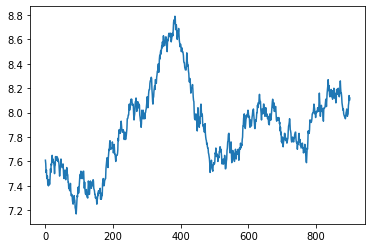

5th percentile = 7.34
95th percentile = 8.57


In [ ]:
avg_reward, total_bad, non_optimal_taxi, rewards = n_episodes_test_compare(policy_Q_Learning, n=1000, text=True, compare=True)
windowed_rewards = np.convolve(rewards, np.ones(100), 'valid')
plt.plot(windowed_rewards/100)
plt.show()
print(f'5th percentile = {np.quantile(windowed_rewards/100, 0.05)}')
print(f'95th percentile = {np.quantile(windowed_rewards/100, 0.95)}')

## Project Documents

- Final training code is pretty simple, there is little change from the code we used in our class. However, there were lots of tuning, trials and experiments done before getting to the final cleaned up codes.

- Such experiments include:
  - playing around with different reward structure
  - dynamically adjusting alpha values during training process
  - customized pretty print function for policy table
  - step by step visual analysis of taxi actions based on trained policy table
  - tuning and adjusting of various hyper parameters
  - developing optimal BFS solution to verify final training results
  - etc.

- Hyper parameter selection
  - gamma: we picked the value of 1.0, since the original reward structure has -1 for default steps, there is no need for using a gamma value smaller than 1.0. However, based on experiments, using values such as 0.9 also converged the training with similar rate
  - n_episodes: based on experiments, the training algorithm usually converges around 3000 iterations. One thing noticed is that since we did not apply a max length limit during training, the training speed is relatively slower at the beginning with around 6 it/s; when coming close to convergence, the training speed is much faster with around 80+ it/s
  - alpha: this is found to be the most important hyper parameter that determines the convergence of the training algorithm for the project. The picked value is mostly based on trial and error. But some very rough estimation might be something like this: if alpha=0.001, then for the return table to reach the optimal value, it needs at least 1000 iterations; also at the beginning, since return table has all 0 values, it will take much more than 1000 iterations to reach the optimal value; however, we also observed that it is not necessary for the return table to reach optimal value to generate an optimal policy table, so there is still lots of uncertainty for this estimation. One general guideline I found that might be useful (could be wrong) is to use a relatively larger alpha to quickly find the trend of convergence, then adjust it to smaller values to improve training accuray or avoid over training, etc.
  
- The other thought is that for static environment, maybe we can train from backwards, since the final done state always have a fixed reward, so their neighouring cell will be able to derive optimal solution much easier. It is understood that in more realistic case, environment will be more dynamic and complex, in which case training from backwards may not be feasible or may have little difference compared to normal training.